### TODO:

* non-human character gender count (versus human) - better aggregation
* add all female/male subjects (singular and plural) to verb clause detection e.g. ['she', 'girl', 'woman', 'mum', 'mother', 'lady', 'sister', 'daughter']
* for found words, store in dataframe instead of lists (with metadata: character it relates to, book found in etc)
* make tables for all word types
* make wordlcouds

### TO DISCUSS:
* names of secondary characters?
* other sentence structures to capture?
* need validation?

### Other ideas:
* how often does he/she appear as subject/object of verb clause?

### Resources:

- https://github.com/peter3125/enhanced-subject-verb-object-extraction (better than standard Spacy for subject-verb-object extraction)
- https://nbviewer.jupyter.org/gist/nealcaren/5105037 (how the Times writes about men and women)
- https://spacy.io/usage/linguistic-features
- https://stackoverflow.com/questions/40288323/what-do-spacys-part-of-speech-and-dependency-tags-mean

In [95]:
import os
import pdfplumber
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import spacy
from spacy import displacy
from spacy.lang.en.examples import sentences 

%matplotlib inline

In [57]:
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe(nlp.create_pipe('sentencizer'))

In [58]:
doc = nlp("She eats the apple hungrily")
#doc = nlp("He was lazy")

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

She -PRON- PRON PRP nsubj Xxx True True
eats eat VERB VBZ ROOT xxxx True False
the the DET DT det xxx True True
apple apple NOUN NN dobj xxxx True False
hungrily hungrily ADV RB advmod xxxx True False


In [59]:
displacy.render(doc, style="dep", options={'distance':120});

In [63]:
spacy.explain('dobj')

'direct object'

In [64]:
labels = pd.read_excel('../Book List Exel April.xlsx', sheet_name='Sheet1')
labels = labels.rename(columns={'Author ': 'Author'})
#labels.loc[labels.Title=='The Gruffalo']

In [65]:
os.chdir('../text_pdfs')

In [66]:
df = pd.DataFrame()

def grab_text(title, labels):
    
    start = labels.loc[labels.Title==title]['Starting Page']
    if len(start)==0:
        print(title, "no start")
        start = 0
    else:
        start = start.values[0]
    end = labels.loc[labels.Title==title]['Ending Page']
    if len(end)==0:
        print(title, "no end")
        end = 0
    else:
        end = end.values[0]
    
    title = title + '.pdf'
    all_text = ''
    with pdfplumber.open(title) as pdf:
        for i, page in enumerate(pdf.pages):
            if i+1 >= start and i < end:
                single_page_text = page.extract_text()

                if single_page_text is not None:
                    all_text = all_text + '\n' + single_page_text
                
    return all_text

df['Title'] = [file.split('.')[0] for file in os.listdir()]
df['Text'] = [grab_text(title, labels) for title in df.Title]

In [67]:
df.head()

,Title,Text
0,The Gruffalo,\nA mouse took a stroll through the deep dark ...
1,Peace at Last,\n \nThe hour was late. \n \nMr Bear was tired...
2,Kipper's Toybox,\nSomeone or something had been \nnibbling a h...
3,The Hungry Caterpillar,\n \nIn the light of the moon a little egg lay...
4,Harry and the Dinosaurs Go Wild,\nIt was a long drive to the safari park but i...


In [68]:
test = df.loc[0].Text.replace('\n', ' ').replace('  ', ' ')
#test[0:50]
test[51:98]

'A fox saw the mouse and the mouse looked good. '

#### This is an example of it failing (mouse should be dobj in this sentence):

Note: would this work better https://github.com/peter3125/enhanced-subject-verb-object-extraction

In [70]:
doc = nlp(test[51:98])
#doc = nlp(test[0:50])
#doc = nlp(test)

# for token in doc:
#     print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
#             token.shape_, token.is_alpha, token.is_stop)

In [71]:
displacy.render(doc, style="dep", options={'distance':100});

#### So, we want to get any he/she that appears, and the verbs and nouns that are associated with them.

#### Then we will extend to use named entities also (with named characeters and their genders from the excel sheet).

Other ideas:
- get noun chunks
- get adjectival modifiers (child of noun) for gendered nouns
- get nsubj for each verb
- get dobj for verbs with gendered nsubj

In [72]:
female_identifiers =['she', 'girl', 'woman', 'mum', 'mother', 'lady', 'sister', 'daughter',
                   'girls', 'women', 'mums', 'mothers', 'ladies', 'sisters', 'daughters']

male_identifiers = ['he', 'boy', 'man', 'dad', 'father', 'guy', 'brother', 'son',
                   'boys', 'men', 'dads', 'fathers', 'guys', 'brothers', 'sons']


In [73]:
doc = nlp(test)

In [74]:
test_female_verbs = list()
test_male_verbs = list()

for title, text in zip(df.Title, df.Text):
    text = ' '.join(text.replace('\n', ' ').split())
    doc = nlp(text)

    for possible_subject in doc:
            if possible_subject.dep_ == 'nsubj' and possible_subject.head.pos_ == 'VERB':
                
                if possible_subject.head.lemma_ == "’":
                    #print(possible_subject.head, [child for child in possible_subject.head.children])
                    #print(title)
                    lem = 'be'
                else:
                    lem = possible_subject.head.lemma_
                    
                #if possible_subject.lower_ == 'he':
                if possible_subject.lower_ in male_identifiers:
                    test_male_verbs.append(lem)
                #elif possible_subject.lower_ == 'she':    
                elif possible_subject.lower_ in female_identifiers:    
                    test_female_verbs.append(lem)

In [76]:
print(len(test_male_verbs))
print(len(test_female_verbs))

757
249


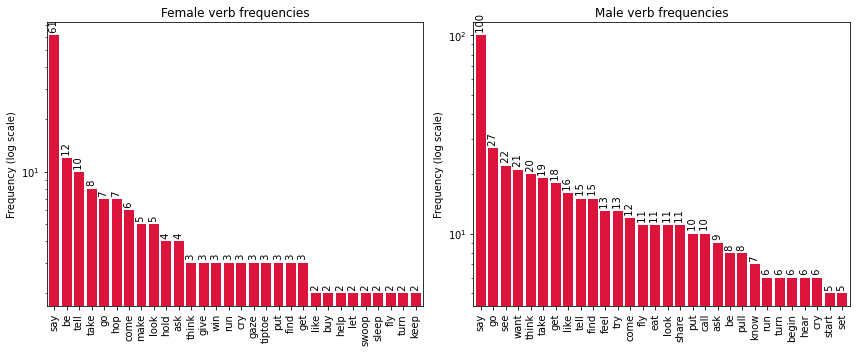

In [77]:
N = 30

def bar_word_freqs(word_list, title, N=N):
    vf = Counter(word_list)
    total = int(sum(vf.values()))
    y = [count for tag, count in vf.most_common(N)]
    x = [tag for tag, count in vf.most_common(N)]

    plt.bar(x, y, color='crimson')
    plt.title(title)
    plt.ylabel("Frequency (log scale)")
    plt.yscale('log')
    plt.xticks(rotation=90)
    for i, (tag, count) in enumerate(vf.most_common(N)):
        plt.text(i, count, f' {count} ', rotation=90,
                 ha='center', va='bottom', 
                 color='black')
#                  ha='center', va='top' if count < 6 else 'bottom', 
#                  color='white' if count < 6 else 'black')
    plt.xlim(-0.6, len(x)-0.4)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
bar_word_freqs(test_female_verbs, "Female verb frequencies")

plt.subplot(1,2,2)
bar_word_freqs(test_male_verbs, "Male verb frequencies")

plt.tight_layout()

#### Now we do the same, but including the named characters.

And we extract the following words (see diagrams below):
- verb associated with the noun subject in each sentence (nsubj)
- adverbs associated with that verb (advmod)
- nouns that are the object of the verb (dobj)
- adjectives associated with the noun subject (amod and acomp)

#### To clarify the word types:

In [87]:
demo_sentence = "She ate the dark chocolate hungrily."
doc = nlp(demo_sentence)
displacy.render(doc, style="dep", options={'distance':120});

In [81]:
demo_sentence = "The fat mouse looked good."
doc = nlp(demo_sentence)
displacy.render(doc, style="dep", options={'distance':120});

In [88]:
labels['Protagonist Gender'].unique()

array([nan, 'F/M/M', 'M', 'NGS PLURAL', 'NGS', 'F/M', 'F', 'M PLURAL ',
       'M  ', 'M/M', 'NGS/NGS ', 'M/NGS/NGS/NGS/NGS', 'PLURAL NGS',
       'NGS SINGULAR AND PLURAL', 'NGS MANY'], dtype=object)

In [89]:
labels['Protagonist Name'].unique()

array([nan, 'Sarah/Percy/Bill', 'Eddy', 'we', 'Percy', 'Grinch ',
       'innkeeper', 'little dove', 'Elmer', 'Jake', 'Sir Charlie ',
       'Harry', 'monkey', 'snail / whale', 'McTat ', 'witch', 'Superworm',
       'Mouse', "Gruffalo's child", 'Charlie Cook', 'Norman', 'duck',
       'cavemen/dinos', 'Kipper', 'Postman', 'Dave/Dogger', 'boy',
       'Baby bear', 'Arthur', 'Mr Bear', 'dog/frog', 'I', 'ladybird',
       'Squash', 'caterpillar', 'spider', 'ladybird/it',
       'Danny/dinosaur dino', 'Badger/animals/Rabbit/Fox/Mice/Robin',
       'Bubble/Squeak', 'Santa', 'Jasper', 'crocodile', 'Sophie/Tiger',
       'Scruffy Bear', 'Cyril/Bruce', 'I/we', 'Monkey', 'Pearl/Zog',
       'Stick Man', 'Janet / Bill', 'Zog', 'Supertato', 'Hippo', 'Lion',
       'Elephant', 'Giraffe', 'Tiger'], dtype=object)

In [90]:
female_verbs = list()
male_verbs = list()

female_ads = list()
male_ads = list()

female_advs = list()
male_advs = list()

female_nouns = list()
male_nouns = list()

def add_words(noun, adv, adj, noun_list, adv_list, adj_list):
    if noun is not None:
        noun_list.append(noun)
    if adv is not None:
        adv_list.append(adv)
    if adj is not None:
        adj_list.append(adj)
        
    return noun_list, adv_list, adj_list

for title, text in zip(df.Title, df.Text):
    text = text.replace('\n', ' ')
    doc = nlp(text)
    
    protagonist = labels.loc[labels.Title==title]['Protagonist Name'].values
    protagonist_gender = labels.loc[labels.Title==title]['Protagonist Gender'].values

    for possible_subject in doc:
            if possible_subject.dep_ == 'nsubj' and possible_subject.head.pos_ == 'VERB':
                
                if possible_subject.head.lemma_ == "’":
                    #print(possible_subject.head, [child for child in possible_subject.head.children])
                    #print(title)
                    lem = 'be'
                else:
                    lem = possible_subject.head.lemma_
                    
                noun = None
                adv = None
                adj = None
                for child in possible_subject.head.children:
                    if child.dep_ == 'dobj':
                        noun = child.lower_ #.lemma_
                    elif child.dep_ == 'acomp':
                        adj = child.lower_ #.lemma_
                    elif child.dep_ == 'advmod':
                        adv = child.lower_ #.lemma_
                    
                if possible_subject.lower_ in male_identifiers:
                    male_verbs.append(lem)
                    male_nouns, male_advs, male_ads = add_words(noun, adv, adj, male_nouns, male_advs, male_ads)
                    
                elif possible_subject.lower_ in female_identifiers:    
                    female_verbs.append(lem)
                    female_nouns, female_advs, female_ads = add_words(noun, adv, adj, female_nouns, female_advs, female_ads)
                    
                if len(protagonist) == 1 and isinstance(protagonist[0], str):
                    protagonist = protagonist[0].split('/')
                    protagonist_gender = protagonist_gender[0].split('/')
                    
                    for p, pg in zip(protagonist, protagonist_gender):
                        #print(p, pg)
                        if possible_subject.lower_ == p.lower():
                            if pg == 'M':
                                male_verbs.append(lem)
                                male_nouns, male_advs, male_ads = add_words(noun, adv, adj, male_nouns, male_advs, male_ads)
                            elif pg == 'F':
                                female_verbs.append(lem)
                                female_nouns, female_advs, female_ads = add_words(noun, adv, adj, female_nouns, female_advs, female_ads)
#                 if not(np.isnan(protagonist) and np.isnan(protagonist_gender)):
#                     if len(protagonist_gender.split('/')) == 1:
                        

In [91]:
print("Without named protagonists we had: %d female verbs and %d male verbs." % (len(test_female_verbs), len(test_male_verbs)))
print("Now, with named protagonists we had: %d female verbs and %d male verbs." % (len(female_verbs), len(male_verbs)))

print("We also have:")

print("%d female adverbs and %d male adverbs" %(len(female_advs), len(male_advs)))
print("%d female adjectives and %d male adjectives" %(len(female_ads), len(male_ads)))
print("%d female nouns and %d male noun" %(len(female_nouns), len(male_nouns)))


Without named protagonists we had: 249 female verbs and 757 male verbs.
Now, with named protagonists we had: 293 female verbs and 1157 male verbs.
We also have:
58 female adverbs and 278 male adverbs
6 female adjectives and 42 male adjectives
87 female nouns and 372 male noun


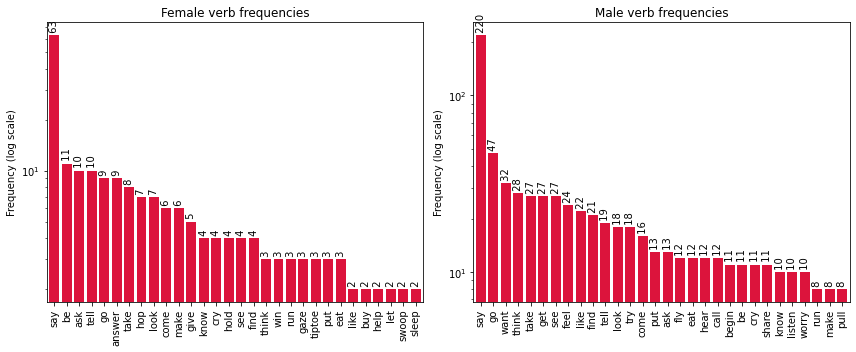

In [92]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
bar_word_freqs(female_verbs, "Female verb frequencies")

plt.subplot(1,2,2)
bar_word_freqs(male_verbs, "Male verb frequencies")

plt.tight_layout()

In [119]:
Counter(female_verbs).dict()

AttributeError: 'Counter' object has no attribute 'dict'

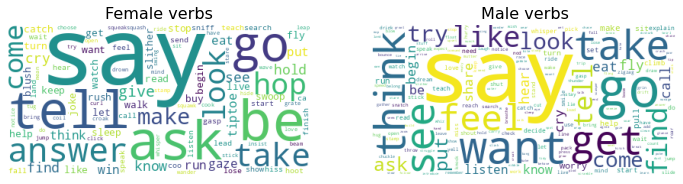

In [123]:
tfs = 16

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Female verbs', fontsize=tfs)
wc = WordCloud(background_color='white').generate_from_frequencies(Counter(female_verbs))
plt.imshow(wc)
plt.axis('off');

plt.subplot(1,2,2)
plt.title('Male verbs', fontsize=tfs)
wc = WordCloud(background_color='white').generate_from_frequencies(Counter(male_verbs))
plt.imshow(wc)
plt.axis('off');

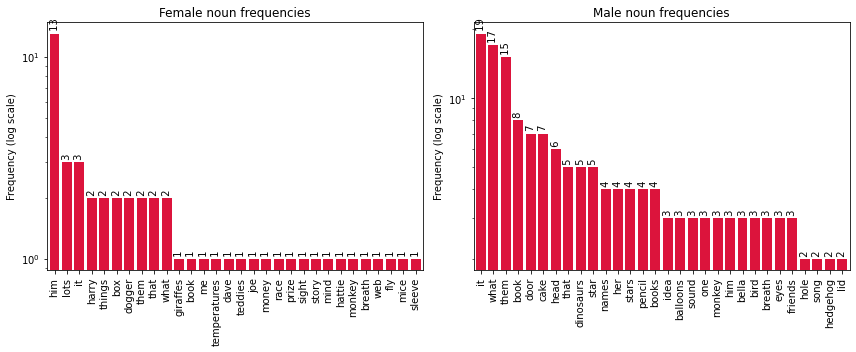

In [125]:
ft = "Female noun frequencies"
mt = "Male noun frequencies"
fw = female_nouns
mw = male_nouns

# ft = "Female adjective frequencies"
# mt = "Male adjective frequencies"
# fw = female_ads
# mw = male_ads

# ft = "Female adverb frequencies"
# mt = "Male adverb frequencies"
# fw = female_advs
# mw = male_advs

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
bar_word_freqs(fw, ft)

plt.subplot(1,2,2)
bar_word_freqs(mw, mt)

plt.tight_layout()

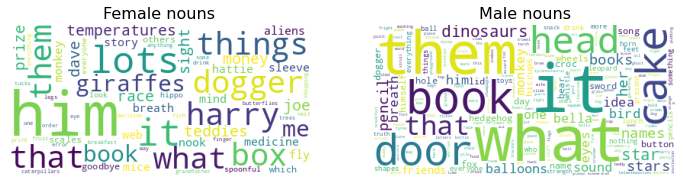

In [126]:
tfs = 16

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Female nouns', fontsize=tfs)
wc = WordCloud(background_color='white').generate_from_frequencies(Counter(female_nouns))
plt.imshow(wc)
plt.axis('off');

plt.subplot(1,2,2)
plt.title('Male nouns', fontsize=tfs)
wc = WordCloud(background_color='white').generate_from_frequencies(Counter(male_nouns))
plt.imshow(wc)
plt.axis('off');

In [137]:
Counter(female_verbs).most_common(20)

[('say', 63),
 ('be', 11),
 ('ask', 10),
 ('tell', 10),
 ('go', 9),
 ('answer', 9),
 ('take', 8),
 ('hop', 7),
 ('look', 7),
 ('come', 6),
 ('make', 6),
 ('give', 5),
 ('know', 4),
 ('cry', 4),
 ('hold', 4),
 ('see', 4),
 ('find', 4),
 ('think', 3),
 ('win', 3),
 ('run', 3)]

#### Adjectival modifiers:

In [149]:
#demo_sentence = "All the people said very good, clever boy!"
demo_sentence = "Their new baby brother"
doc = nlp(demo_sentence)
displacy.render(doc, style="dep", options={'distance':120});

In [150]:
female_adjs = list()
male_adjs = list()

for title, text in zip(df.Title, df.Text):
    text = text.replace('\n', ' ')
    doc = nlp(text)
    
    protagonist = labels.loc[labels.Title==title]['Protagonist Name'].values
    protagonist_gender = labels.loc[labels.Title==title]['Protagonist Gender'].values

    for possible_amod in doc:
            if possible_amod.dep_ == 'amod' and possible_amod.head.pos_ == 'NOUN':
                
#                 if possible_subject.head.lemma_ == "’":
#                     #print(possible_subject.head, [child for child in possible_subject.head.children])
#                     #print(title)
#                     lem = 'be'
#                 else:
#                     lem = possible_subject.head.lemma_
                lem = possible_amod.lemma_
                    
                if possible_amod.head.lower_ in male_identifiers:
                    male_adjs.append(lem)
                    #print(possible_amod.sent)
                    #print(possible_amod.head.lower_, lem)
                elif possible_amod.head.lower_ in female_identifiers:    
                    female_adjs.append(lem)
                    #print(possible_amod.head.lower_, lem)
                    
                if len(protagonist) == 1 and isinstance(protagonist[0], str):
                    protagonist = protagonist[0].split('/')
                    protagonist_gender = protagonist_gender[0].split('/')
                    
                    for p, pg in zip(protagonist, protagonist_gender):
                        if possible_amod.head.lower_ == p.lower():
                            #print(p.lower(), lem)
                            if pg == 'M':
                                male_adjs.append(lem)
                            elif pg == 'F':
                                female_adjs.append(lem)

                        

In [128]:
print(len(female_adjs))
print(len(male_adjs))

12
25


In [129]:
Counter(male_adjs).most_common(20)

[('little', 10),
 ('brown', 3),
 ('scary', 2),
 ('good', 2),
 ('new', 2),
 ('tiny', 1),
 ('young', 1),
 ('clever', 1),
 ('special', 1),
 ('beware', 1),
 ('stuck', 1)]

In [130]:
Counter(female_adjs).most_common(20)

[('lazy', 10), ('poor', 1), ('old', 1)]

### Things to resolve:

1. Plural genders (e.g. cavemen)
2. Double barrel names (e.g. Stick Man, Charlie Cook etc)- replace with single token? (e.g. Stick_Man)
3. Add his/hers e.g. "His favourite food is roasted fox"
4. Add recognition of who is speaking. e.g. "I'm going to have lunch with a gruffalo"

Need to do proper NER rather than just using nsubj?

#### Examples of sentence structures that are not currently being detected:

In [132]:
demo_sentence = "Charlie Cook was very hungry."
doc = nlp(demo_sentence)
displacy.render(doc, style="dep", options={'distance':120});

In [133]:
demo_sentence = "His favourite food is roasted fox."
doc = nlp(demo_sentence)
displacy.render(doc, style="dep", options={'distance':120});

In [134]:
demo_sentence = "It wasn't her best idea."
doc = nlp(demo_sentence)
displacy.render(doc, style="dep", options={'distance':120});

In [135]:
demo_sentence = "She said: 'I'm hungry.'"
doc = nlp(demo_sentence)
displacy.render(doc, style="dep", options={'distance':120});

In [136]:
demo_sentence = "He was in the kitchen."
doc = nlp(demo_sentence)
displacy.render(doc, style="dep", options={'distance':120});

### Looking at speech:

In [152]:
for title, text in zip(df.Title, df.Text):
    text = text.replace('\n', ' ')
    doc = nlp(text)
    
    protagonist = labels.loc[labels.Title==title]['Protagonist Name'].values
    protagonist_gender = labels.loc[labels.Title==title]['Protagonist Gender'].values

    for possible_subject in doc:
            if possible_subject.dep_ == 'nsubj' and possible_subject.head.pos_ == 'VERB':
                
                if possible_subject.head.lemma_ == "say":
                    print(possible_subject.sent)

Fox said.
the Gruffalo said.
Good?”
said the mouse.
All right, said the Gruffalo, bursting w ith laughter.
They walked and walked till the Gruffalo said, “I hear    a hiss in the leaves ahead. ’
"It’s Snake,” said the mouse.
he said, “Goodbye, little mouse" And off he    slid to his logpile house.
said the mouse.
said the Gruffalo.
They waited some more till the Gruffalo said, “I hear    a hoot in the trees ahead. ”
It’s Owl," said the mouse.
he said, “Goodbye, little mouse"
said the mouse.
said the Gruffalo.
They walked some more till the Gruffalo said, “I can    hear feet on the path ahead.
“It’s Fox,” said the mouse.
he said, “Goodbye, little mouse,” And    off he ran to his underground house.
Well, Gruffalo, said the mouse.
Well, Gruffalo, said the mouse.
the Gruffalo said, And quick as the wind he    turned and fled.
said Mr Bear, “I can’t stand THIS.”
said Mr Bear, “I can’t stand THIS.”
said Mr Bear, “I can’t stand THIS!”
“Oh NO,” said Mr Bear,  “I can’t stand THIS.”
said Mr Bear

Said the tiny snail.
And she gazed at the sky, the sea, the land,   The waves and the caves and the golden sand, She gazed and gazed, amazed by it all, And she said    to the whale, “I feel so small.”
say the  children.
And the flock on the rock,   Who said, “How time’s flown!”
And the flock on the rock,   Who said, “How time’s flown!”
Janet, like all the Smeds, was red, And    this is what her grandfather said:
Till who should, disturb them    but Grandfather Smed,   Shaking his fist as he angrily said:
For the hundredth time I say to you,    Never, never play with a Smoo."
I’ll say again what I’ve always    
But what do you think their    grandparents said?
The Smeds said, “Your Bill must have stolen our Janet    And taken her off to a distant planet.”
The Smoos said, “It’s Janet who’s stolen our Bill And lured    him away from the humplety hill.”
And they said to the Smeds,   
Then Grandfather Smed said, “My hair needs a trim,” And Grandmother    Smoo kindly cut it for him.
Alas,” s

“It must be a Christmas card,” said Badger,  tearing open the envelope.
‘Let’s get to work,” said Santa.
“First we’ll need gifts,” said Santa, fetching their  letters.
“We’ll need pinecones, holly and mistletoe,” said  Badger.
“We’re ready to load the sleigh,” said Santa.
“How kind you all are,” said Mrs Bear.
said Badger.
The Grinch simply said,   "If I can’t find a reindeer, I'll mail one instead!”
Then the Grinch said, "Giddap!"
Well… in Who-ville they say That the  Grinch’s small heart Grew three times that day!
"Good morning,” said the friendly ladybird.
Oh, you’re not big enough for me to fight,” it said.
"Hey you,” said the bad- tempered ladybird.
"Hey you,” said the bad- tempered ladybird.
If you insist,” said  the wasp, showing its  stinger.
Oh, you’re not big  enough,” said the bad- tem pered ladybird and flew  off.
Hey you," said  the bad-tempered ladybird.
If you  insist,” said the stag beetle,  opening its jaws.
Hey  you,” said the bad- tempered ladybird.
Hey  you,” said t

Said Eddy.
said Eddy.
‘You’re too big to huddle and cuddle,’ he said,    ‘
You’re too small to huddle  and cuddle,” it said, “and  you’ll only get lost in my  giant-sized bed!”
 The Gruffalo said that no gruffalo should Ever set foot in the deep dark wood.
I met him once,” said the Gruffalo.
“I cant quite remember, ” the Gruffalo said.
Not I,” said the snake.
Not I,” said the snake.
“I’m not scared,” said the Gruffalo’s Child.
“I’m not scared,’’ said the Gruffalo’s Child.
said the Gruffalo’s Child As she sat on a stump where the snow  lay piled.
“Wait!”
said the mouse.
Elephant said the paints  were his and he did not want to share  them.
Elephant said he wanted his snack for himself.
Little Lion said Elephant did not need all  the books at once.
He said Elephant could only read  one book at a time.
But Elephant said he wanted all  the books for himself.
Miss Bird said Elephant  could not stay in the library corner if he did not share  nicely.
Everyone wanted to play with it, but Eleph